# Gaussianization from Scratch

In [ ]:
!pip install "git+https://github.com/IPL-UV/rbig.git"

In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])

# append to path
sys.path.append(str(root))

%load_ext autoreload
%autoreload 2

## Import Packages

In [2]:
import numpy as np

from sklearn.datasets import make_moons

# Packages
import numpy as np
import pytorch_lightning as pl


# Plot
import matplotlib.pyplot as plt
import corner

import wandb
pl.seed_everything(1234)

%load_ext autoreload
%autoreload 2

Global seed set to 1234


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Logging

In [3]:
# TODO

## Data

In [4]:
ntrain = 10_000
ntest = 10_000
noise = 0.1
random_state = 123
train_data = make_moons(n_samples=ntrain, noise=noise, random_state=random_state)[0]
test_data = make_moons(n_samples=ntest, noise=noise, random_state=random_state*10)[0]

### Plot Data

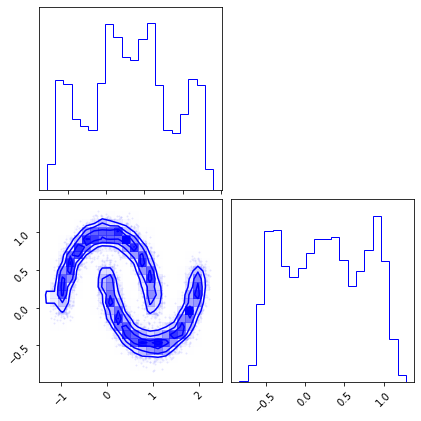

In [5]:
fig = plt.figure(figsize=(7, 7))

corner.corner(train_data, color="blue", fig=fig)

plt.show()

## Flow Transformation

## Univariate Gaussianization

### Uniformization

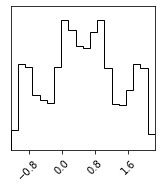

In [25]:
X_1 = train_data[:, 0][:, None]
X_2 = train_data[:, 1][:, None]

fig = corner.corner(X_1)

In [7]:
from rbig._src.uniform import MarginalHistogramUniformization

In [26]:
hist_uni_bijector = MarginalHistogramUniformization(X_1)

In [42]:
from typing import NamedTuple, Callable, Union
from scipy import stats


class UnivariateHistogram:
    def __init__(self, X: np.ndarray, bins: Union[int,str]=10, alpha: float=1e-10, bound_ext: float=0.1):
        
        diff = X.max() - X.min()
        lower_bound = X.min() - bound_ext * diff
        upper_bound = X.max() + bound_ext * diff

        # create histogram 
        hist = np.histogram(X, bins=bins, range=(lower_bound, upper_bound))

        # create histogram object
        estimator = stats.rv_histogram(hist)

        # add some regularization
        estimator._hpdf += alpha
        
        self.estimator = estimator
        
    def forward(self, X):
        
        return self.estimator.cdf(X)
    
    def inverse(self, X):
        
        return self.estimator.ppf(X)
    
    def gradient(self, X):
        
        return self.estimator.pdf(X)

In [43]:
hist_uni_bijector = UnivariateHistogram(X_1, bins="scott")

#### Forward Transformation

In [27]:
Xu_1 = hist_uni_bijector.forward(X_1)

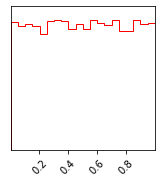

In [28]:
fig = corner.corner(Xu_1, color="red")

#### Inverse Transformation

In [29]:
X_1_approx = hist_uni_bijector.inverse(Xu_1)

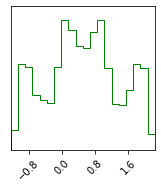

In [30]:
fig = corner.corner(X_1_approx, color="green")

#### Det Jacobian

In [31]:
Xldj_1 = hist_uni_bijector.gradient(X_1)

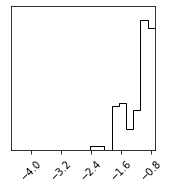

In [32]:
fig = corner.corner(Xldj_1)

### Density Estimation

In [33]:
from scipy import stats

base_dist = stats.uniform()

In [34]:
# latent probability
pz = base_dist.pdf(Xu_1)

# det jacobian
det_jacobian = hist_uni_bijector.gradient(X_1)

# total prob
p_x = pz.sum(axis=1) * det_jacobian

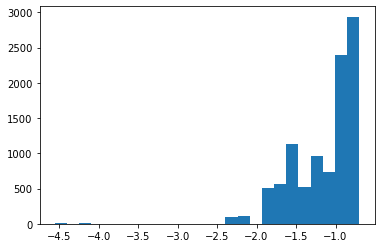

In [35]:
fig, ax = plt.subplots()
ax.hist(p_x, bins=25)
plt.show()

### Sampling

In [37]:
# generate samples in uniform domain
pz_samples = base_dist.rvs(size=10_000)[:, None]

# propagate them through
X_1_samples = hist_uni_bijector.inverse(pz_samples)

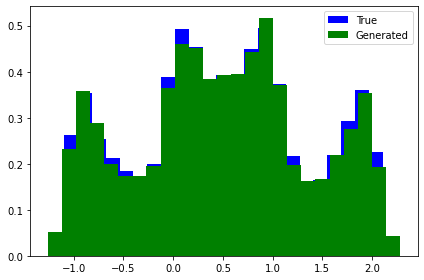

In [38]:
fig, ax = plt.subplots()
ax.hist(X_1, bins=25, color='blue', density=True, label="True")
ax.hist(X_1_samples, bins=25, color='green', density=True, label="Generated")
plt.legend()
plt.tight_layout()
plt.show()

### Inverse CDF

In [30]:
class InverseGaussCDF:
    def __init__(self, eps: float=1e-5):
        self.eps = eps
        
        # create histogram object
        self.estimator = stats.norm(loc=0, scale=1)
    
    def forward(self, X):
        
        X = np.clip(X, self.eps, 1-self.eps)
        
        Z = self.estimator.ppf(X)
        
        return Z
        
    def inverse(self, Z):
        X = self.estimator.cdf(Z)
        
        return X
    
    def gradient(self, X):
        X = self.inverse(X)
        
        det_jacobian = - self.estimator.pdf(X)
        
        return det_jacobian


def inverse_cdf(eps: float=1e-5):
    
    
    
    def forward(X):
        

        
        return X
    
    def inverse(X):
        
        
        
        
        return X
    
    def gradient(X):
        
        
        
        
        
        return X
    
    
    return Bijector(
        forward=forward, 
        inverse=inverse, 
        gradient=gradient
    )

In [39]:
from rbig._src.invcdf import InverseGaussCDF

In [40]:
invcdf_bijector = InverseGaussCDF(eps=1e-7)

#### Forward

In [41]:
Xg_1 = invcdf_bijector.forward(Xu_1)

#### Inverse

In [42]:
Xu_1_approx = invcdf_bijector.inverse(Xg_1)

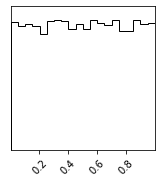

In [43]:
fig = corner.corner(Xu_1_approx)

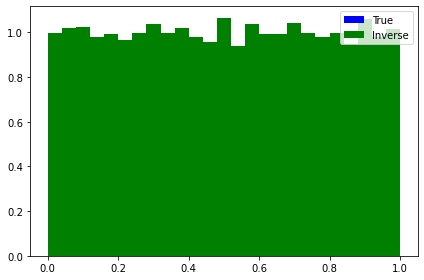

In [44]:
fig, ax = plt.subplots()
ax.hist(Xu_1, bins=25, color='blue', density=True, label="True")
ax.hist(Xu_1_approx, bins=25, color='green', density=True, label="Inverse")
plt.legend()
plt.tight_layout()
plt.show()

#### Gradient

In [45]:
Xg_1_gradient = invcdf_bijector.gradient(Xu_1)

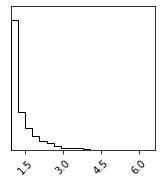

In [46]:
fig = corner.corner(Xg_1_gradient)

#### Density Estimation

In [49]:
# 1) uniformization
Xu_1 = hist_uni_bijector.forward(X_1)
det_jacobian_u = hist_uni_bijector.gradient(X_1)

# 2) gaussianization
Xg_1 = hist_uni_bijector.forward(Xu_1)
det_jacobian_g = hist_uni_bijector.gradient(Xu_1)

# latent probability
base_dist = stats.norm(loc=0, scale=1)

pz = base_dist.pdf(Xg_1).sum(axis=1)



# total prob
p_x = pz * det_jacobian_g * det_jacobian_u

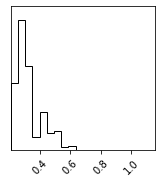

In [50]:
fig = corner.corner(p_x)

#### Sampling

In [51]:
# 1) samples from latent probability
base_dist = stats.norm(loc=0, scale=1)
pz_samples = base_dist.rvs(size=10_000)[:, None]

# 2) inverse gaussianization
Xu_1_samples = hist_uni_bijector.inverse(pz_samples)

# 3) inverse uniformization
X_1_samples = hist_uni_bijector.inverse(Xu_1_samples)

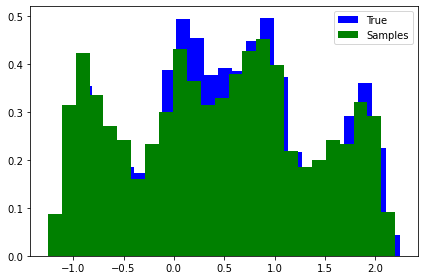

In [52]:
fig, ax = plt.subplots()
ax.hist(X_1, bins=25, color='blue', density=True, label="True")
ax.hist(X_1_samples, bins=25, color='green', density=True, label="Samples")
plt.legend()
plt.tight_layout()
plt.show()

## 